In [25]:
from nastran.aero.analysis.flutter import FlutterSubcase
import numpy as np

from nastran.structures.panel import IsotropicPlate, LaminatedStructuralPlate
from nastran.structures.material import OrthotropicMaterial, IsotropicMaterial
from nastran.aero.superpanels import SuperAeroPanel5
from nastran.aero.analysis.panel_flutter import PanelFlutterPistonAnalysisModel, PanelFlutterSubcase

In [26]:

## Setup structural model
a, b = 300., 300
p1 = np.array([0, 0, 0])
p2 = p1 + np.array([a, 0, 0])
p3 = p1 + np.array([a, b, 0])
p4 = p1 + np.array([0, b, 0])

nchord, nspan = 20, 20

- E = 71.7 GPa
- G = 26.9 GPa
- nu = 0.33
- rho = 2.81 g/cm³

In [27]:
al = IsotropicMaterial(1, 71700., .33, 26900, 2.81e-9)
al.to_mat1()

MAT1           1  71700.  26900.     .33  2.81-9

In [28]:
plate = IsotropicPlate.create_plate(p1, p2, p3, p4, nspan, nchord, 1, 1.5, al)
print(plate.bdf.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.nodes
  GRID     : 441

bdf.elements
  CQUAD4   : 400

bdf.properties
  PSHELL   : ???

bdf.materials
  MAT1     : 1




In [29]:
# %%

config = {
    'vref': 1000.,                      # used to calculate the non-dimensional dynamic pressure must be the same in control case (mm/s in the case)
    'ref_rho': 1.225e-12,               # air density reference (ton/mm^3 in the case)
    'ref_chord': 300.,                  # reference chord (mm in the case)
    'n_modes': 4,                      # number searched modes in modal analysis
    'frequency_limits': 
        [.0, 1000.],                    # the range of frequency (Hz) in modal analysis
    'method': 'PK',                     # the method for solving flutter (it will determine the next parameters
    'densities_ratio': [.5],            # rho/rho_ref -> 1/2 simulates the "one side flow" of the panel (? reference ?)
    'machs': [3.],      # Mach numbers
    'alphas': [.0, .0, .0, .0],         # AoA (°) -> 0 is more conservative (? reference ?)
    'reduced_frequencies': 
        [.001, .1, .2, .4],    # reduced frequencies (k) (check influence)
    'velocities':                       # velocities (mm/s in the case)
        np.linspace(822, 1066, 50)*1000,
}

params =  {
    'VREF': 1000.0,
    'COUPMASS': 1,
    'LMODES': 4,
    'WTMASS': 1.,
    'GRDPNT': 1,
    'OPPHIPA': 1,
    # 'POST': [-1]
}

analysis = PanelFlutterPistonAnalysisModel(plate.bdf, params=params)
analysis.set_global_case_from_dict(config)

In [30]:
from nastran.structures.bc import create_spcs_and_subcases, generate_bc_case, create_springs


spc_cases = {
    # 1: generate_bc_case('SSSS'),
    1: generate_bc_case('SSSS')
}

nodes = plate.limit_nodes()
nodes[2] = nodes[2][1:-1]
nodes[3] = nodes[3][1:-1]

create_spcs_and_subcases(analysis, spc_cases, nodes, PanelFlutterSubcase)
# create_springs(analysis, plate.limit_nodes())

# %%

spanel_p = SuperAeroPanel5(1, p1, p2, p3, p4, nchord, nspan, theory='VANDYKE')
analysis.add_superpanel(spanel_p)


# %%

analysis.write_cards()


Aerodynamic Flutter solution created!


In [31]:
analysis.model

In [32]:

# %%
analysis.model.write_bdf('test/nmodes-15.bdf', enddata=True)

# %%

In [21]:

#%%
from nastran.aero.post import read_f06

df = read_f06("test/no-temp-metallic-bush.f06")



In [22]:
df

KFREQ  1./KFREQ   VELOCITY   DAMPING  \
SUBCASE MACH NUMBER POINT INDEX                                          
1       3.0         1.0   0      0.1465  6.827804   822.0000 -0.105648   
                          1      0.1474  6.785119   826.9796 -0.104988   
                          2      0.1484  6.738003   831.9592 -0.104259   
                          3      0.1496  6.685604   836.9388 -0.103449   
                          4      0.1509  6.626683   841.9184 -0.102537   
...                                 ...       ...        ...       ...   
                    4.0   45     0.2746  3.641496  1046.0820 -0.056990   
                          46     0.2728  3.665123  1051.0610 -0.057360   
                          47     0.2711  3.689046  1056.0410 -0.057734   
                          48     0.2693  3.713276  1061.0200 -0.058113   
                          49     0.2675  3.737842  1066.0000 -0.058497   

                                 FREQUENCY  REALEIGVAL  IMAGEIGVAL  
SUBCASE MACH NUMBER POINT INDEX                                     
1       3.0         1.0   0      127.73786  -42.396594   802.60064  
                          1      129.32016  -42.653532   812.54250  
                          2      131.00857  -42.910494   823.15114  
                          3      132.82565  -43.167489   834.56816  
                          4      134.80398  -43.424534   846.99838  
...                                    ...         ...         ...  
                    4.0   45     304.79983  -54.571214  1915.11380  
                          46     304.27641  -54.830846  1911.82500  
                          47     303.73550  -55.090522  1908.42640  
                          48     303.17628  -55.350137  1904.91280  
                          49     302.59739  -55.609793  1901.27540  

[200 rows x 7 columns]

In [23]:
#%%
from nastran.aero.post import get_critical_roots
critic_df = get_critical_roots(df)
critic_df
#%%

,,,KFREQ,1./KFREQ,VELOCITY,DAMPING,FREQUENCY,REALEIGVAL,IMAGEIGVAL
SUBCASE,MACH NUMBER,POINT,,,,,,,
1,3.0,2.0,0.16765,5.965187,869.3061,0.0,154.623965,-6.701473,971.53104


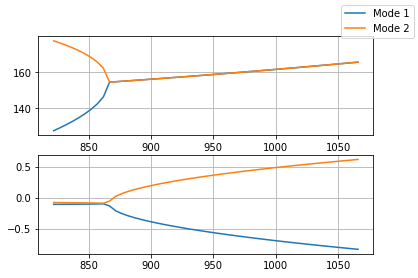

In [24]:

from nastran.aero.post import plot_vf_vg

p = plot_vf_vg(df.loc[(df.index.get_level_values(2) == 1.0) | (df.index.get_level_values(2) == 2.0)])
# x = df.xs(15, level='POINT')
# x
# a = x.xs(2.0, level='MACH NUMBER')
# b = x.xs(3.0, level='MACH NUMBER')
# plt.plot(a.VELOCITY, a.DAMPING)
# plt.plot(b.VELOCITY, b.DAMPING)



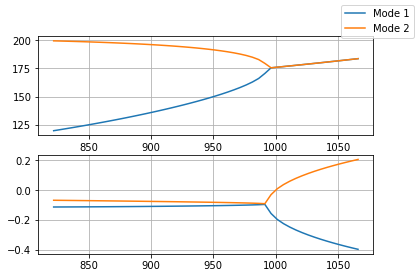

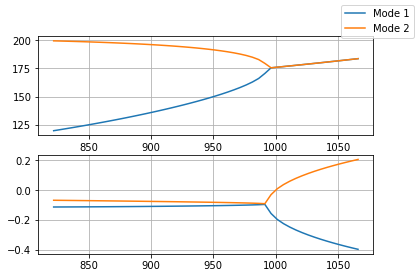

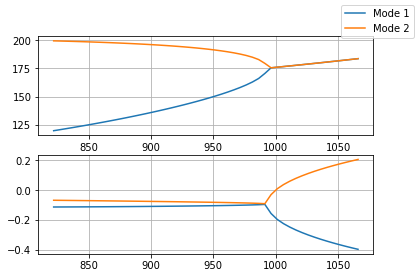

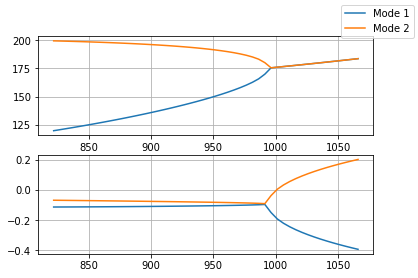

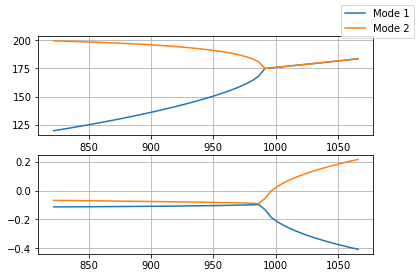

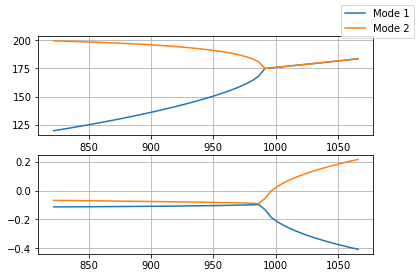

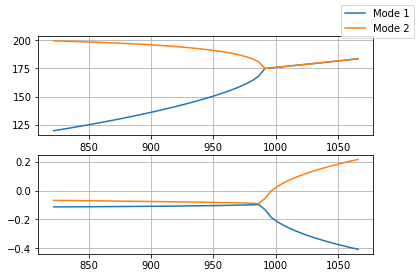

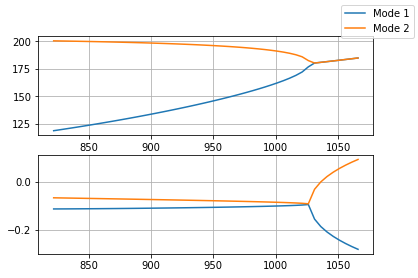

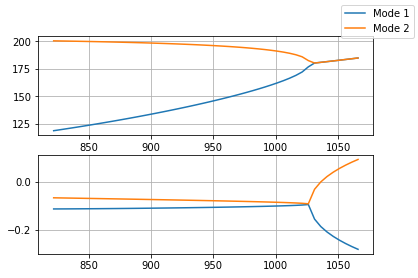

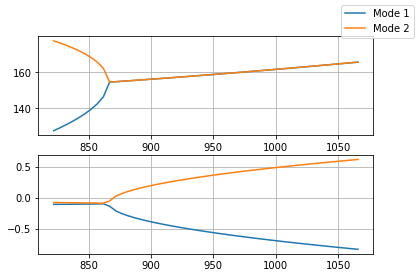

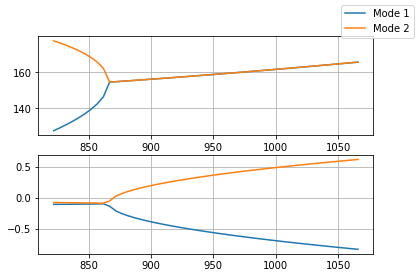

In [2]:

#%%
from nastran.aero.post import read_f06

from nastran.aero.post import plot_vf_vg

nmodes = [20, 19, 17, 15, 13, 11, 10, 8, 6, 4, 3]

for n in nmodes:
    df = read_f06("test/nmodes-study/nmodes-{}.f06".format(n))
    p = plot_vf_vg(df.loc[(df.index.get_level_values(2) == 1.0) | (df.index.get_level_values(2) == 2.0)])
    # p = plot_vf_vg(df)
